# Load sign embeddings

In [11]:
import io
import numpy as np

def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

print("Setup complete.")

Setup complete.


In [39]:
## PMI+SVD ############################
dim=32
# src_path = './embeddings/pmi_svd/output/PE_nonnumeric.txt.{0}.vec'.format(dim)
# tgt_path = './embeddings/pmi_svd/output/PC_nonnumeric.txt.{0}.vec'.format(dim)
# ########
# src_path = './embeddings/pmi_svd/output/PE.txt.{0}.vec'.format(dim)
# tgt_path = './embeddings/pmi_svd/output/PC.txt.{0}.vec'.format(dim)

## fastText ############################
# src_path = './embeddings/fastText/models/PE_nonnumeric.cbow.vec'
# tgt_path = './embeddings/fastText/models/PC_nonnumeric.cbow.vec'
# ########
# src_path = './embeddings/fastText/models/PE_nonnumeric.skip.vec'
# tgt_path = './embeddings/fastText/models/PC_nonnumeric.skip.vec'
# ########
# src_path = './embeddings/fastText/models/PE.cbow.vec' 
# tgt_path = './embeddings/fastText/models/PC.cbow.vec' 
# ########
# src_path = './embeddings/fastText/models/PE.skip.vec'
# tgt_path = './embeddings/fastText/models/PC.skip.vec'

# GloVe ###############################
src_path = './embeddings/glove/data/PE.txt.vec' 
tgt_path = './embeddings/glove/data/PC.txt.vec' 

## MUSE ############################
# src_path = './embeddings/aligned/fastText/vectors-pe_supervised.vec'
# tgt_path = './embeddings/aligned/fastText/vectors-pc_supervised.vec'
# src_path = './embeddings/aligned/fastText/vectors-pe_unsupervised.vec'
# tgt_path = './embeddings/aligned/fastText/vectors-pc_unsupervised.vec'
# ########
# src_path = './embeddings/aligned/pmi/vectors-pe_supervised.vec'
# tgt_path = './embeddings/aligned/pmi/vectors-pc_supervised.vec'
# src_path = './embeddings/aligned/pmi/vectors-pe_unsupervised.vec'
# tgt_path = './embeddings/aligned/pmi/vectors-pc_unsupervised.vec'
# ########
# src_path = './embeddings/aligned/glove/vectors-pe_supervised.vec'
# tgt_path = './embeddings/aligned/glove/vectors-pc_supervised.vec'
# src_path = './embeddings/aligned/glove/vectors-pe_unsupervised.vec'
# tgt_path = './embeddings/aligned/glove/vectors-pc_unsupervised.vec'

nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

print("Loaded embeddings from\n", src_path, "and\n", tgt_path)

Loaded embeddings from
 ./embeddings/glove/data/PE.txt.vec and
 ./embeddings/glove/data/PC.txt.vec


# Nearest neighbors

Given a sign in one script, what signs does the embedding model think are most similar?

In [40]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5, verbose=True):
    if verbose:
        print("Nearest neighbors of \"%s\":" % word)
    nns = []
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        if verbose:
            print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))
        nns.append( (scores[idx], tgt_id2word[idx]) )
    return nns

print("Set up nearest-neighbor function.")

Set up nearest-neighbor function.


In [41]:
# printing nearest neighbors in the source space
src_word = 'M346'
_ = get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=15)

Nearest neighbors of "M346":
1.0000 - M346
0.9518 - M149~A
0.9403 - M153
0.9231 - M367
0.9120 - M362
0.8945 - M001
0.8934 - M006
0.8910 - M365
0.8904 - M072
0.8692 - M418~C
0.8677 - M348
0.8557 - M387~L
0.8466 - N14
0.8397 - M059
0.7850 - M304


Given a sign in one script, which signs from the *other* script are functionally similar?

In [42]:
# printing nearest neighbors in the target space
src_words = ["M157","M388","M346","M072"]
for src_word in src_words:
    _ = get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=15)
    print()

Nearest neighbors of "M157":
0.7160 - ZATU714
0.6368 - N28
0.6295 - N30~C
0.6222 - ERIM2
0.6213 - SI4~A
0.5927 - N25
0.5863 - GARA2~A
0.5791 - HI@G~A
0.5673 - SUM~A
0.5626 - ZATU776
0.5132 - N42~A
0.5071 - E~B
0.4954 - N26
0.4872 - TAR~A
0.4796 - N28~C

Nearest neighbors of "M388":
0.5304 - SZE~A
0.4861 - MUSZEN
0.4358 - GI
0.4239 - KU6~A
0.4179 - HI@G~A
0.4153 - EN~B
0.4124 - GISZ
0.4046 - N28
0.3942 - GUG2
0.3908 - |SZE~A.NAM2|
0.3904 - N39~A
0.3792 - ZATU714
0.3689 - N42~A
0.3509 - X
0.3507 - N24

Nearest neighbors of "M346":
0.5680 - SZEG9
0.5333 - LU2
0.5130 - SZA3~A2
0.5069 - BAN~A
0.4985 - SUM~A
0.4920 - GUM~B
0.4911 - NIN
0.4712 - GAN~B
0.4706 - |KA2XLAM|
0.4636 - NIR~A
0.4547 - |NIR~AXAN|
0.4511 - |SILA3~AXSZE~A@T|
0.4437 - |NINDA2XX|
0.4425 - UTUL~A
0.4413 - N39~B

Nearest neighbors of "M072":
0.5490 - N39~B
0.5469 - SZEG9
0.5360 - GAN~B
0.5285 - SZA3~A2
0.4703 - |KA2XLAM|
0.4621 - KU~B1
0.4561 - ZI~A
0.4521 - N30~C
0.4474 - NIN
0.4457 - BAN~A
0.4401 - |SILA3~AXGARA2~A|
0.438

# Visualize multilingual embeddings

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
# print('Variance: %.2f' % pca.explained_variance_ratio_.sum())

import matplotlib.pyplot as plt

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    scale = 10
    
    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = scale*Y[:, 0]
    y_coords = scale*Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(15, 12), dpi=120)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='normal')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()
    
print("Ready to plot.")

Ready to plot.


Plots a random selection of words from each script. Points which are close together are more likely to have similar usage.

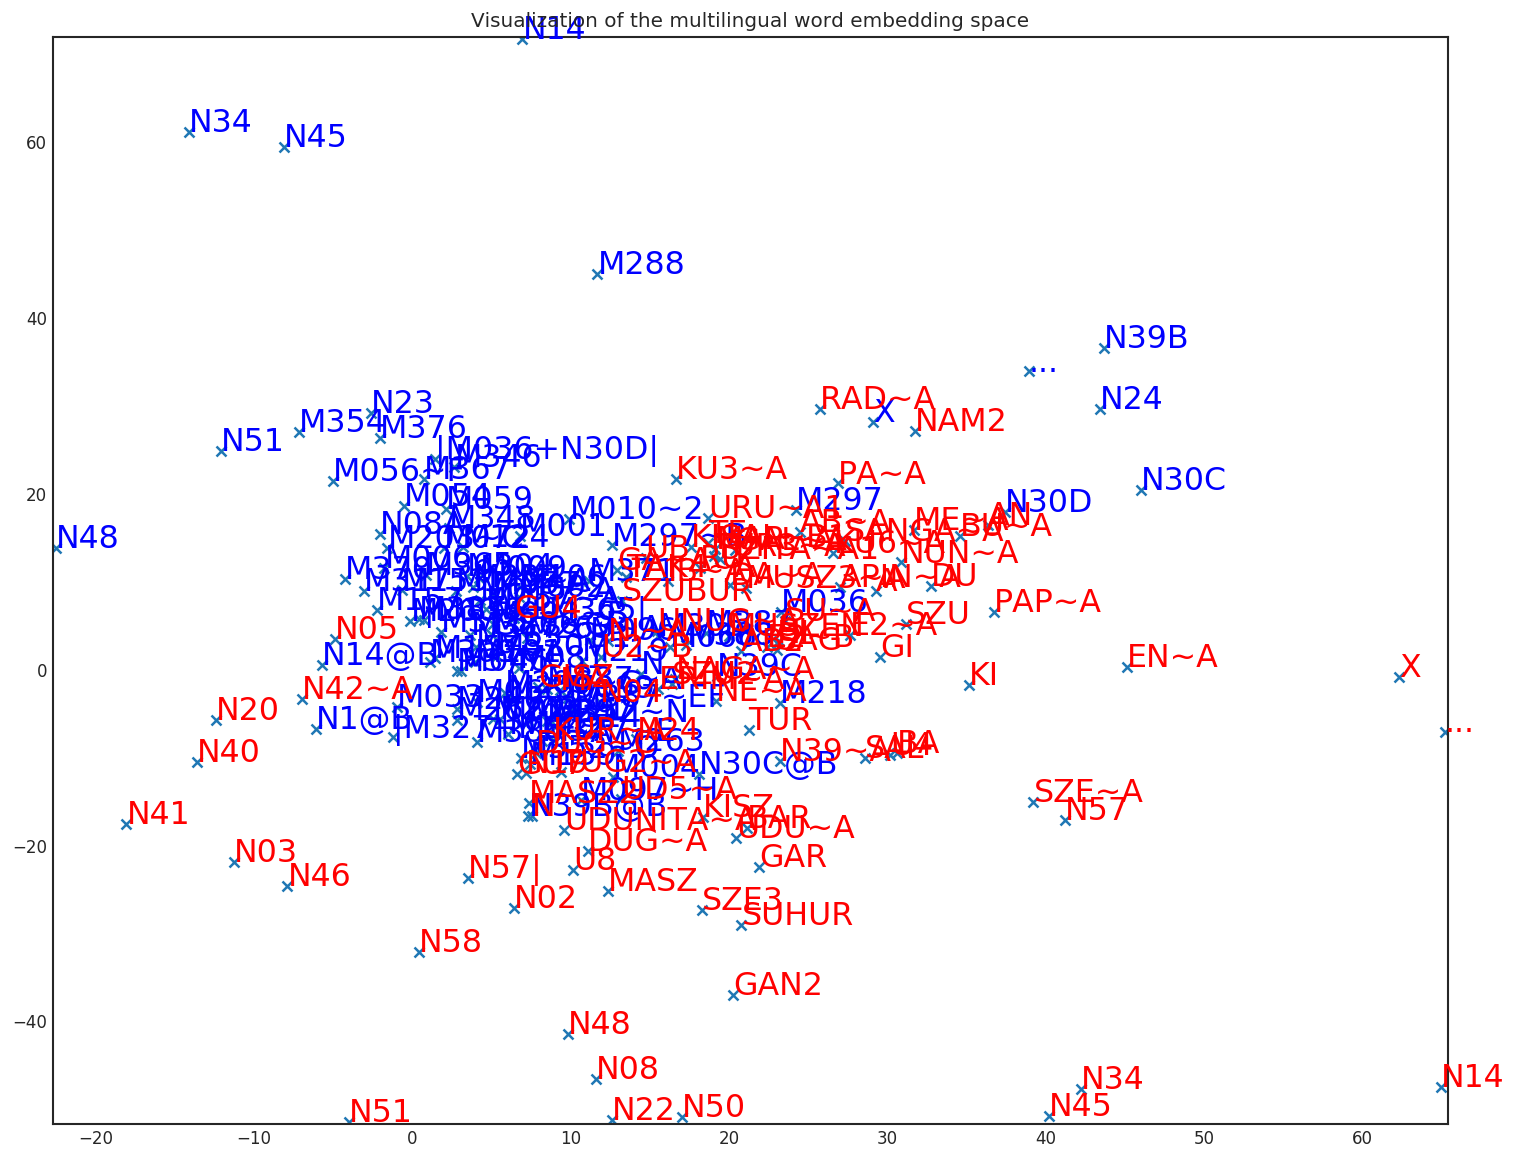

In [44]:
plot_size = 100
src_words = [w for w in src_word2id][:plot_size]
tgt_words = [w for w in tgt_word2id][:plot_size]
# Get the closest target word for source word:
# tgt_words = set([ 
#     get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=1, verbose=False)[0][1] 
#     for src_word in src_words 
# ])

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % tw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

## Highlight source words

See how certain signs cluster within a single script. Plots the entire collection of source words and highlights some signs of interest.

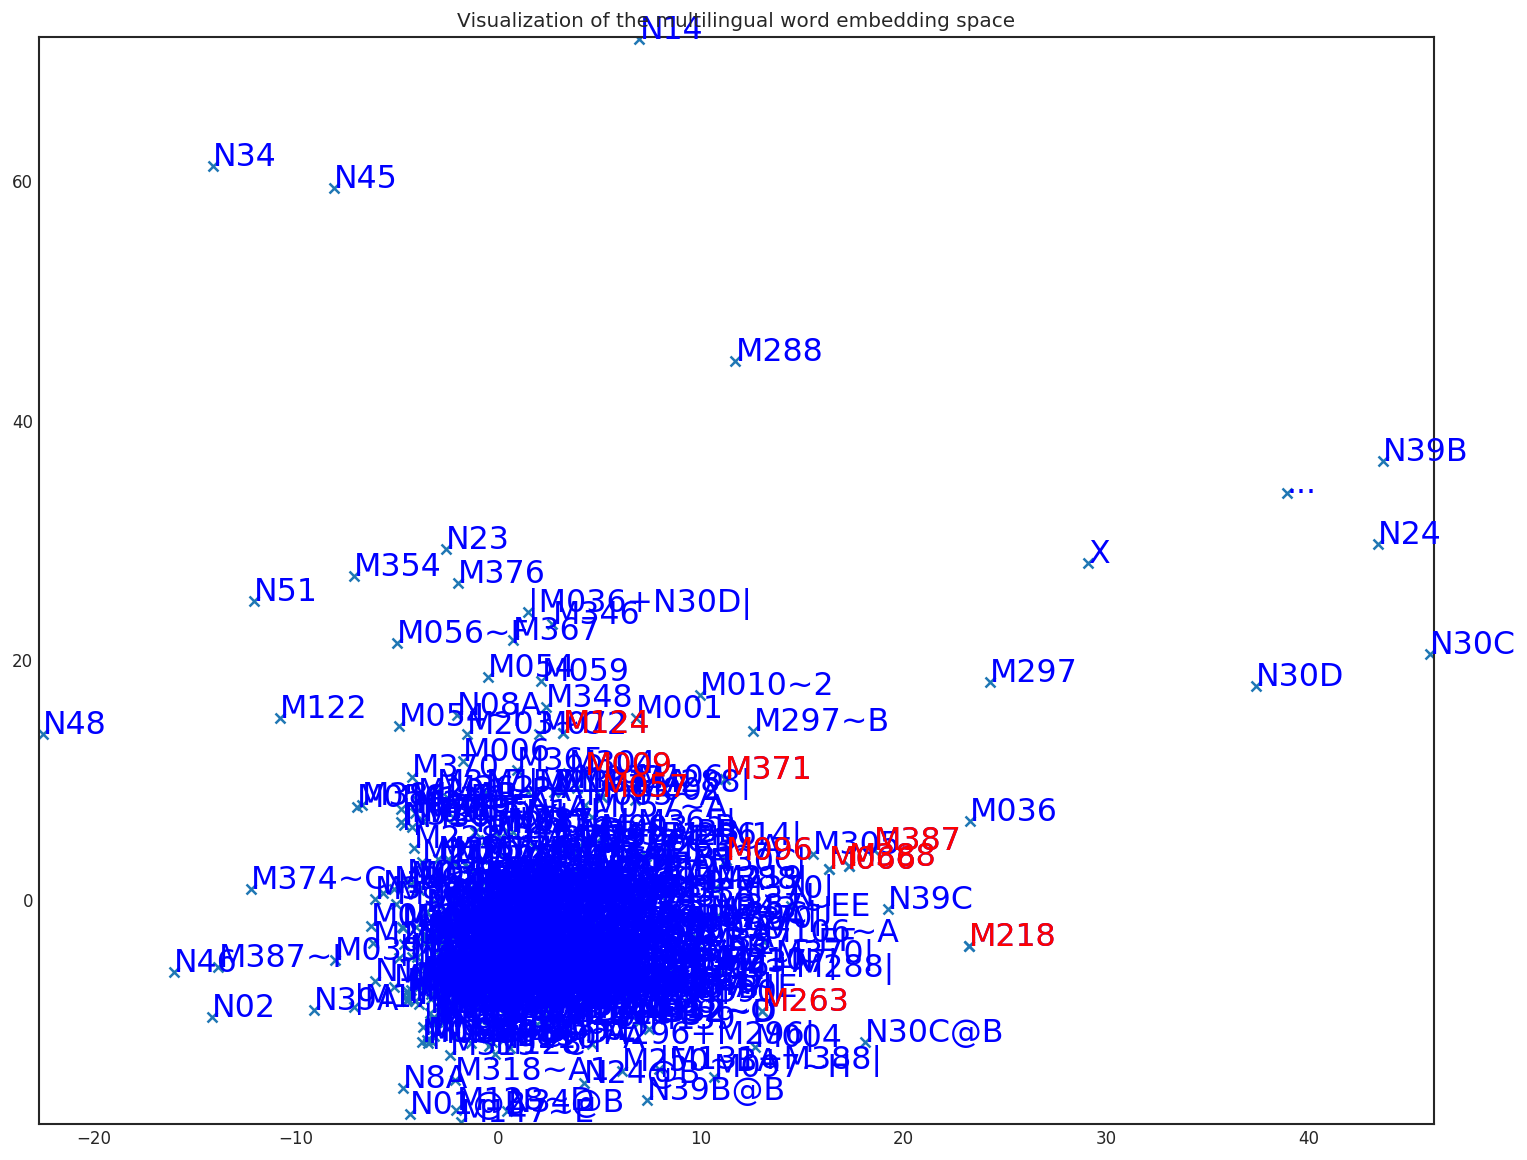

In [45]:
src_words = [w for i,w in enumerate(src_word2id)]
# src_words = [w for i,w in enumerate(src_word2id) if i%1==0] # Plot only 1/3 of the words for readability.
tgt_words =  ["M388","M066","M096","M218","M387","M371","M124","M009","M263","M057"]

for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in src_word2id, '"%s" not in target dictionary' % tw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, src_word2id, src_embeddings, pca)

# Monolingual Clustering
To help evaluate the monolingual embeddings.

Loaded embeddings from
 ./embeddings/glove/data/PE_novars.txt.vec


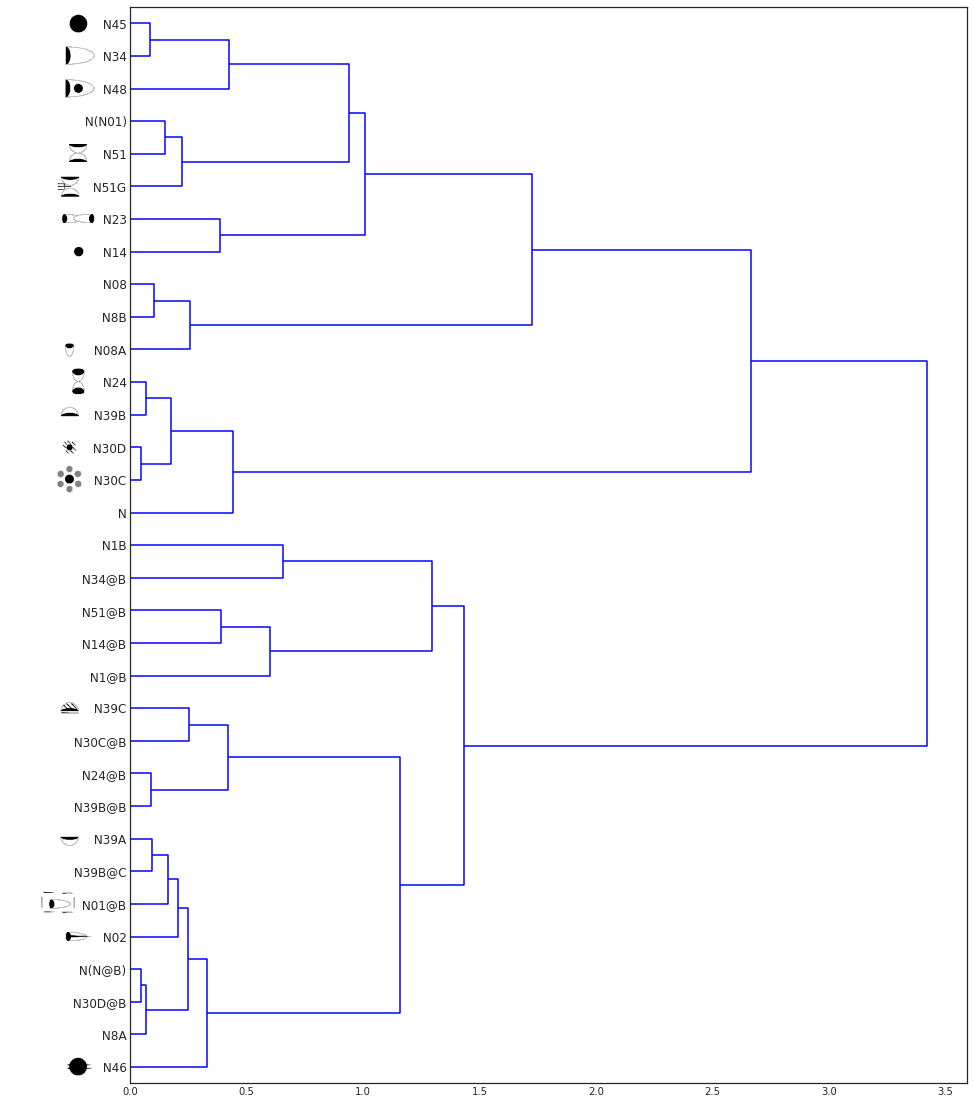

Loaded embeddings from
 ./embeddings/pmi_svd/output/PE.txt.32.vec


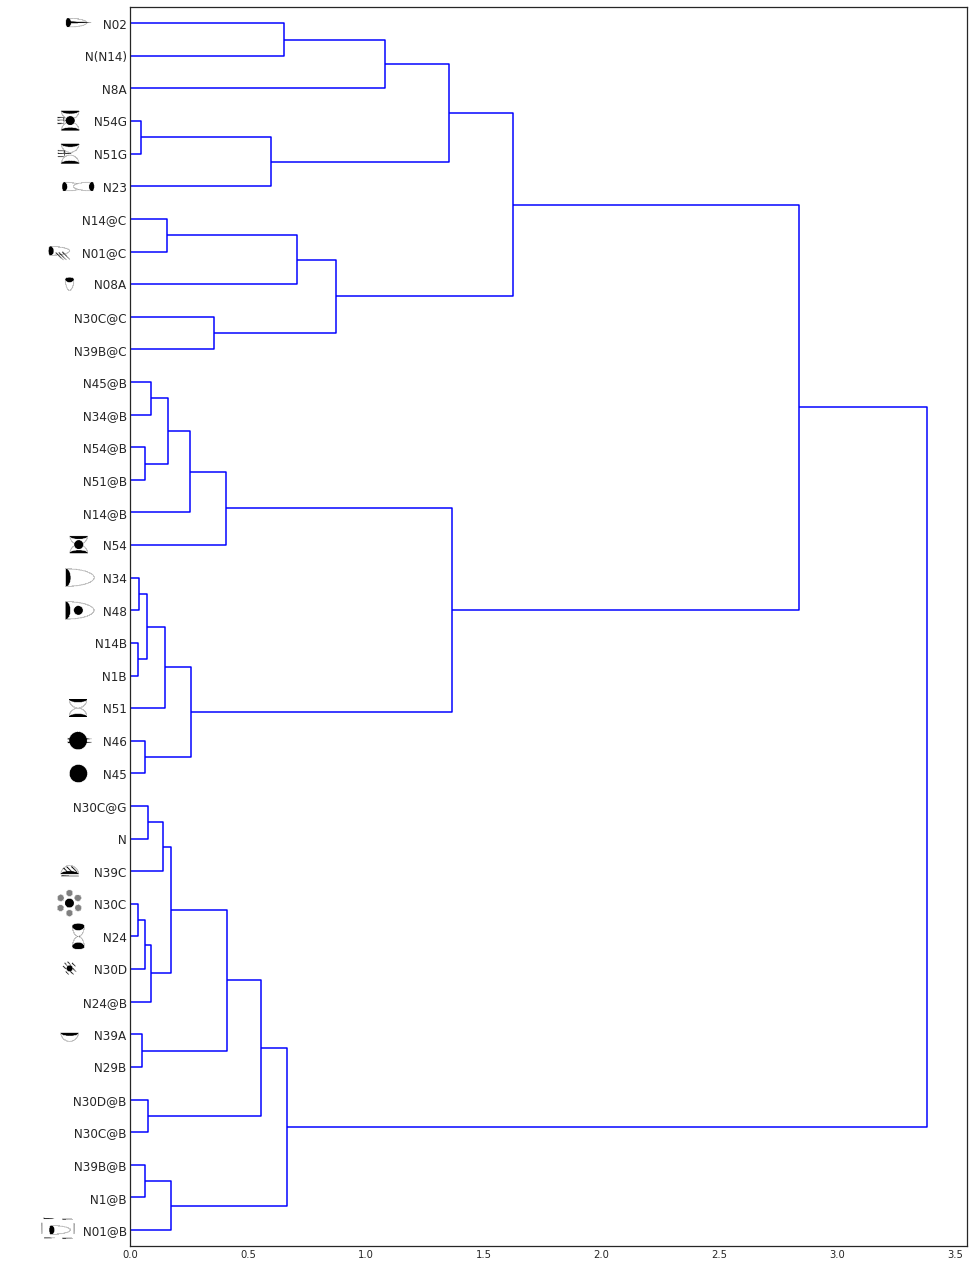

Loaded embeddings from
 ./embeddings/fastText/models/PE.cbow.vec


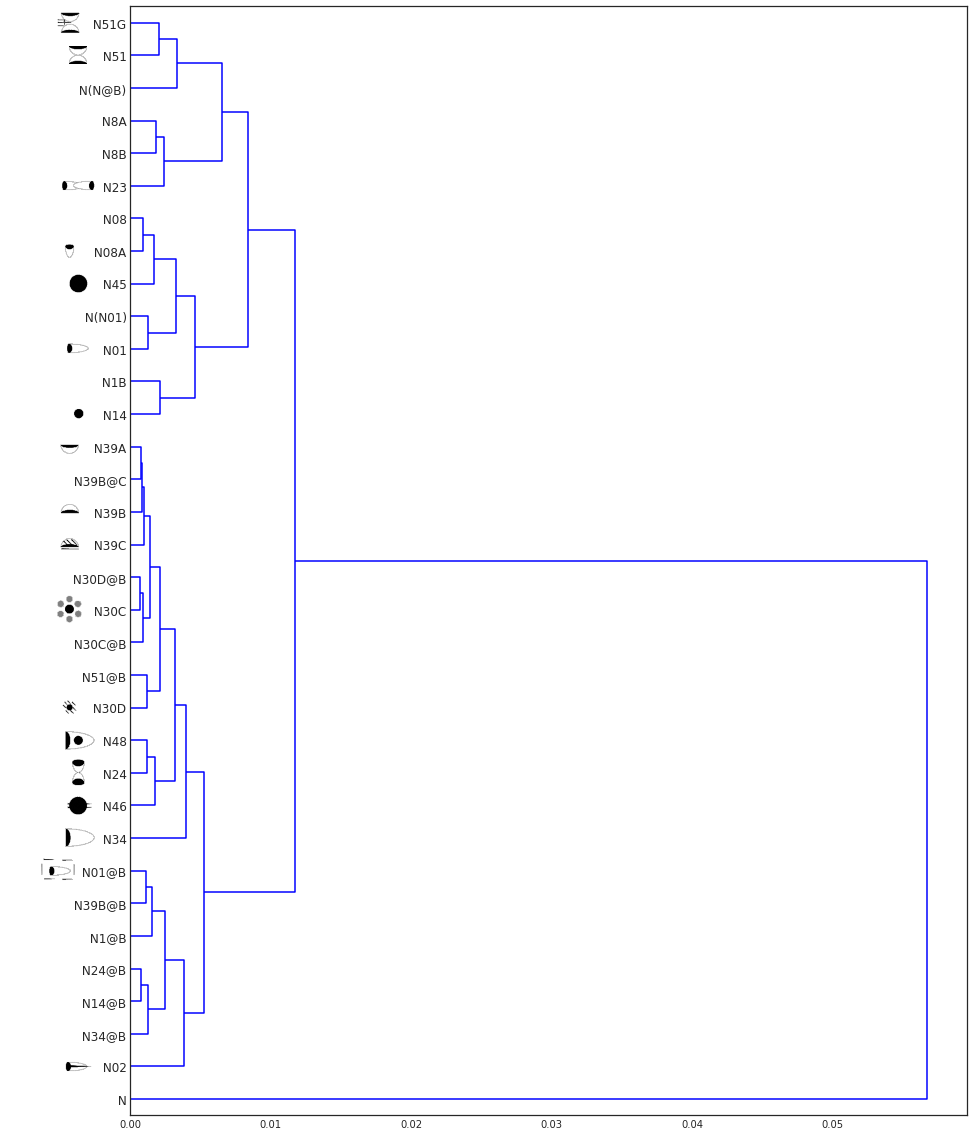

Loaded embeddings from
 ./embeddings/fastText/models/PE.skip.vec


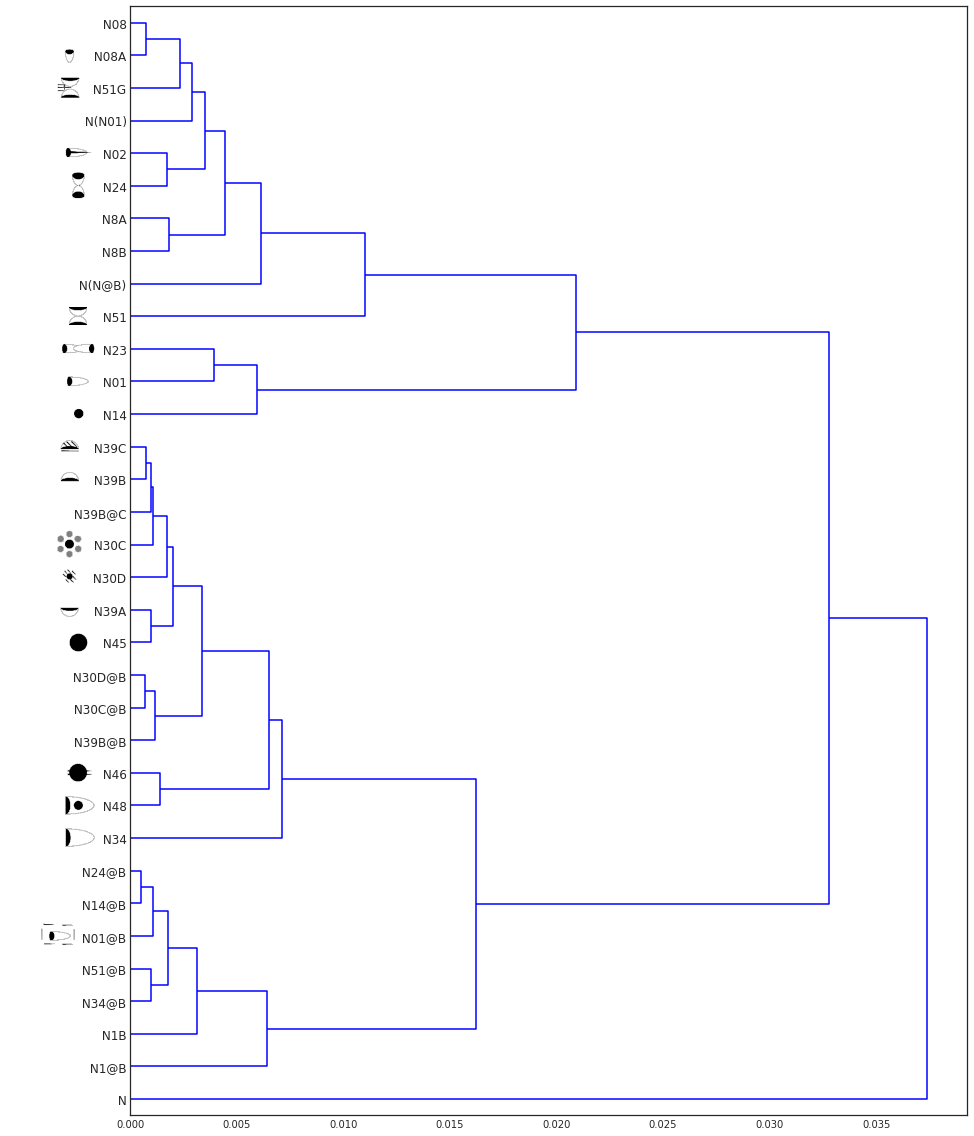

In [38]:
#################################################################
# Edit this to change the number of signs in the dendrogram below:
# The tree will contain all signs which appear at least THRESHOLD
# times in the corpus:
# THRESHOLD = 50
# If NORMALIZE is True, then sign variants are collapsed together
# with their corresponding base sign. This may cause some signs
# to display without pictures beside them, as there are no images
# for some base signs.
NORMALIZE = False

import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from PIL import Image
import PIL.ImageOps


# for src_path in ['./embeddings/pmi_svd/output/PE_nonnumeric.txt.32.vec',
#                  './embeddings/fastText/models/PE_nonnumeric.cbow.vec',
#                  './embeddings/fastText/models/PE_nonnumeric.skip.vec']:
for src_path in ['./embeddings/glove/data/PE_novars.txt.vec',
                 './embeddings/pmi_svd/output/PE.txt.32.vec',
                 './embeddings/fastText/models/PE.cbow.vec',
                 './embeddings/fastText/models/PE.skip.vec',
                ]:

    nmax = 50000  # maximum number of word embeddings to load
    src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
    print("Loaded embeddings from\n", src_path)

    def meets_condition(sign):
        return sign.startswith("N")
    
    # Compute context vectors
    dists = []
    word2id = {v: k for k, v in src_id2word.items()}
    for word in word2id:
        if not meets_condition(word):
            continue
        word_emb = src_embeddings[word2id[word]]
        scores = (src_embeddings / np.linalg.norm(src_embeddings, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
        scores = scores[ np.array([i for i,w in enumerate(word2id) if meets_condition(w)]) ]
        dists.append( 1 - scores )

    reduced_dists = []
    for i,row in enumerate(dists):
        for value in row[i+1:]:
            reduced_dists.append(value)

    # labels, contexts = util.get_contexts( threshold=THRESHOLD, normalizeSigns=NORMALIZE )
#     padded_labels = [ "                 %s" % (word) for word in word2id ]
    ###
    padded_labels = [ "                 %s" % (word) for word in word2id if meets_condition(word) ]

    # # Cluster signs:
#     clusters_neighbor = linkage(reduced_dists, metric='cosine', method='complete')
    clusters_neighbor = linkage(reduced_dists, metric='cosine', method='ward')

    def draw_dendrogram(clusters, labels, highlight=[]):
        max_ = max(c[2] for c in clusters)
        offset = max_ * 1e-2
        clusters = [ [c[0],c[1],c[2]+offset,c[3]] for c in clusters] # add a small offset to make the figure easier to read

        plt.style.use('seaborn-white')

        # Build the dendrogram:
        plt.figure(figsize=(15, 0.6*len(labels)))

        dendrogram(
            clusters,
            leaf_font_size=12.,
            labels=labels,
            orientation='right',
            color_threshold=0.0,
        )

        # Color code symbols of interest to help find them in the diagram:
        ax=plt.gca()
        labels = ax.get_ymajorticklabels()
        label_posns = ax.get_yticks()

        for i,label in enumerate(labels):
            draw_highlight = False
            sign = label.get_text().strip(" ")
            if sign in highlight:
                print("highlighting sign ",sign)
                draw_highlight = True
                label.set_color('red')
            if sign.startswith("N"):
                signimg = "./pngs/PE_num/1("+sign.upper().replace("~","-")+").png"
            else:
                signimg = "./pngs/PE_mainforms/"+sign.upper().replace("~","-")+".png"
            coords = (0,1,label_posns[i]+1,label_posns[i])

            try:
                arr_img = Image.open(signimg)
                arr_img = arr_img.convert("RGBA")

                data = arr_img.getdata()

                newData = []
                for item in data:
                    if item[0] == 255 and item[1] == 255 and item[2] == 255:
                        newData.append((255, 255, 255, 0))
                    else:
                        newData.append(item)

                arr_img.putdata(newData)


                imagebox = OffsetImage(arr_img, zoom=0.45, interpolation='bicubic')
                imagebox.image.axes = ax
                xy = [0,1*label_posns[i]]
                ab = AnnotationBbox(imagebox, xy,
                                    xybox=(-25. + (-9*(len(sign))),0.),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0,
                                    bboxprops=dict(edgecolor='red' if draw_highlight else 'none',alpha=0.5 if draw_highlight else 0)
                                    )
                ax.add_artist(ab)
            except FileNotFoundError:
                pass

        plt.show()

    draw_dendrogram(clusters_neighbor, padded_labels, highlight=[])